In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [3]:
def wrangle_saas_data():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'saas.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
    return df

In [4]:
df = wrangle_saas_data()

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend 
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

Bonus: 
1. Using the store item demand data, create a forecast of `sales_total` and `quantity` for 2018 using the `Previous Cycle` approach.  .  
2. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
4. Plot the 2018 monthly sales predictions.

In [6]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [9]:
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
df = df.set_index('Month_Invoiced').sort_index()

In [18]:
df.shape

(790458, 4)

In [10]:
df_resampled = df.resample('M')[['Amount']].sum()
df_resampled.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [11]:
df_resampled.shape

(48, 1)

In [12]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

24

In [13]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

14

In [14]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

10

In [15]:
len(df_resampled) == train_size + validate_size + test_size

True

In [16]:
# validate will go from 24 to 24 + 14
validate_end_index = train_size + validate_size
validate_end_index

38

In [19]:
# train will go from 0 to 23
train = df_resampled[:train_size]

In [20]:
train.tail()

,Amount
Month_Invoiced,
2015-08-31,50495.0
2015-09-30,50985.0
2015-10-31,51445.0
2015-11-30,51260.0
2015-12-31,51505.0


In [21]:
# validate will go from 24 to 37
validate = df_resampled[train_size:validate_end_index]

In [22]:
validate.head()

,Amount
Month_Invoiced,
2016-01-31,51955.0
2016-02-29,51955.0
2016-03-31,52000.0
2016-04-30,52190.0
2016-05-31,52325.0


In [23]:
validate.tail()

,Amount
Month_Invoiced,
2016-10-31,53190.0
2016-11-30,53375.0
2016-12-31,53320.0
2017-01-31,53395.0
2017-02-28,53440.0


In [24]:
# test will include 1459 to the end
test = df_resampled[validate_end_index:]

In [25]:
test.head()

,Amount
Month_Invoiced,
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0


In [26]:
train.shape[0], validate.shape[0], test.shape[0]

(24, 14, 10)

In [27]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [28]:
print(df_resampled.head(1) == train.head(1))

                Amount
Month_Invoiced        
2014-01-31        True


In [29]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,Amount
Month_Invoiced,
2017-12-31,53805.0
2017-12-31,53805.0


In [30]:
train.columns

Index(['Amount'], dtype='object')

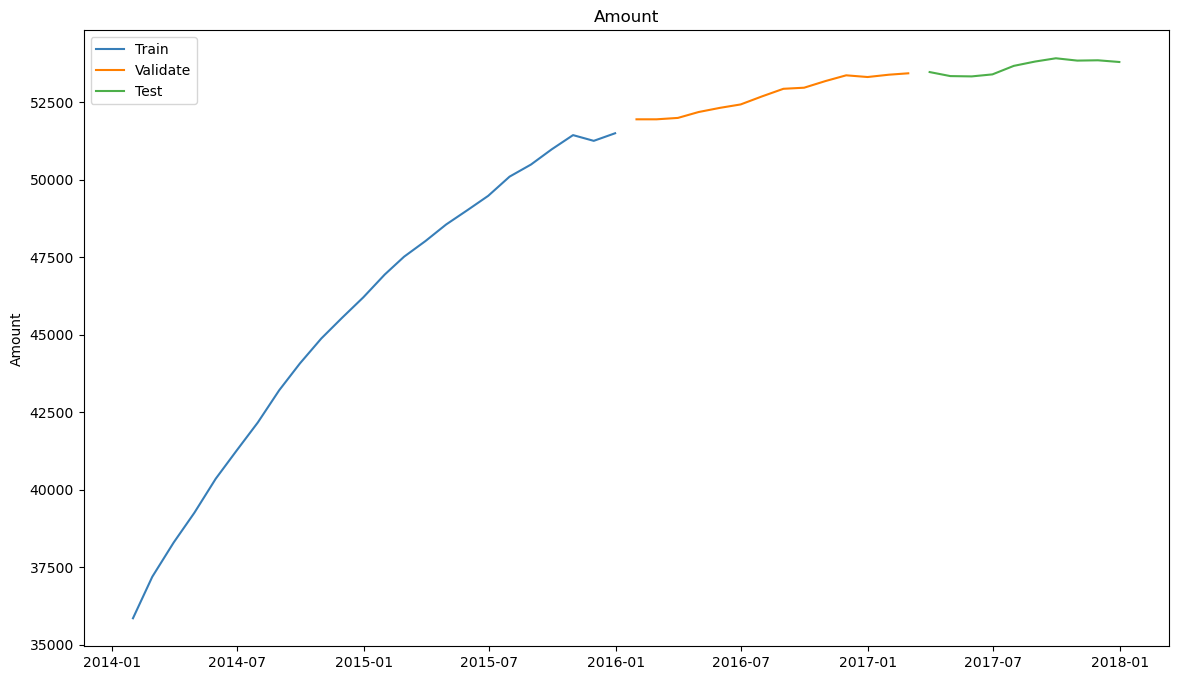

In [31]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [32]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [33]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [34]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [35]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [38]:
train['Amount'][-1:][0]

51505.0

In [39]:
# take the last item of sales total and assign to variable
last_amount = train['Amount'][-1:][0]

In [40]:
yhat_df = pd.DataFrame(
    {'amount_total': [last_amount],
    },
    index=validate.index)

yhat_df.head()

,amount_total
Month_Invoiced,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


In [41]:
# confim that every predicted value is the same with .describe
yhat_df.describe()

,amount_total
count,14.0
mean,51505.0
std,0.0
min,51505.0
25%,51505.0
50%,51505.0
75%,51505.0
max,51505.0


In [57]:
for col in train.columns:
    plot_and_eval(col)

NameError: name 'columns' is not defined